In [1]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import astropy.constants as const


environments = [NLTE.NLTE_model.Environment(T_phot= 4900, photosphere_velocity= 0.30 , line_velocity= 0.30 , t_d=1.17),
                NLTE.NLTE_model.Environment(T_phot= 2800, photosphere_velocity= 0.18, line_velocity= 0.18, t_d=4.40),]

                
#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

Inserting ones for missing states
Max flux:
Radiative                : 23P  -> 23S . Flux: 9.12e+03
Radiative                : 23S  -> 23P . Flux: 9.12e+03
Radiative                : 23P  -> 33D . Flux: 6.01e+02
Radiative                : 33D  -> 23P . Flux: 5.98e+02
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 2.64e+00
Radiative                : 43F  -> 31D . Flux: 2.31e+00
Collision                : 33D  -> 31D . Flux: 2.27e+00
Radiative                : 33D  -> 41F . Flux: 1.44e+00
Photoionization          : 23S  -> HeII. Flux: 1.17e+00
Photoionization          : 33P  -> HeII. Flux: 8.15e-01
Photoionization          : 33D  -> HeII. Flux: 3.58e-01
Photoionization          : 43P  -> HeII. Flux: 3.53e-01
Photoionization          : 43D  -> HeII. Flux: 2.42e-01
Photoionization          : 33S  -> HeII. Flux: 8.03e-02
Radiative                : 33D  -> 21P . Flux: 7.37e-02
Photoionization          : 43F  -> HeII. Flux: 6.88e-02
Radiative                : 23P  -> 

Text(-0.15, 26, '$T = 2800$ K')

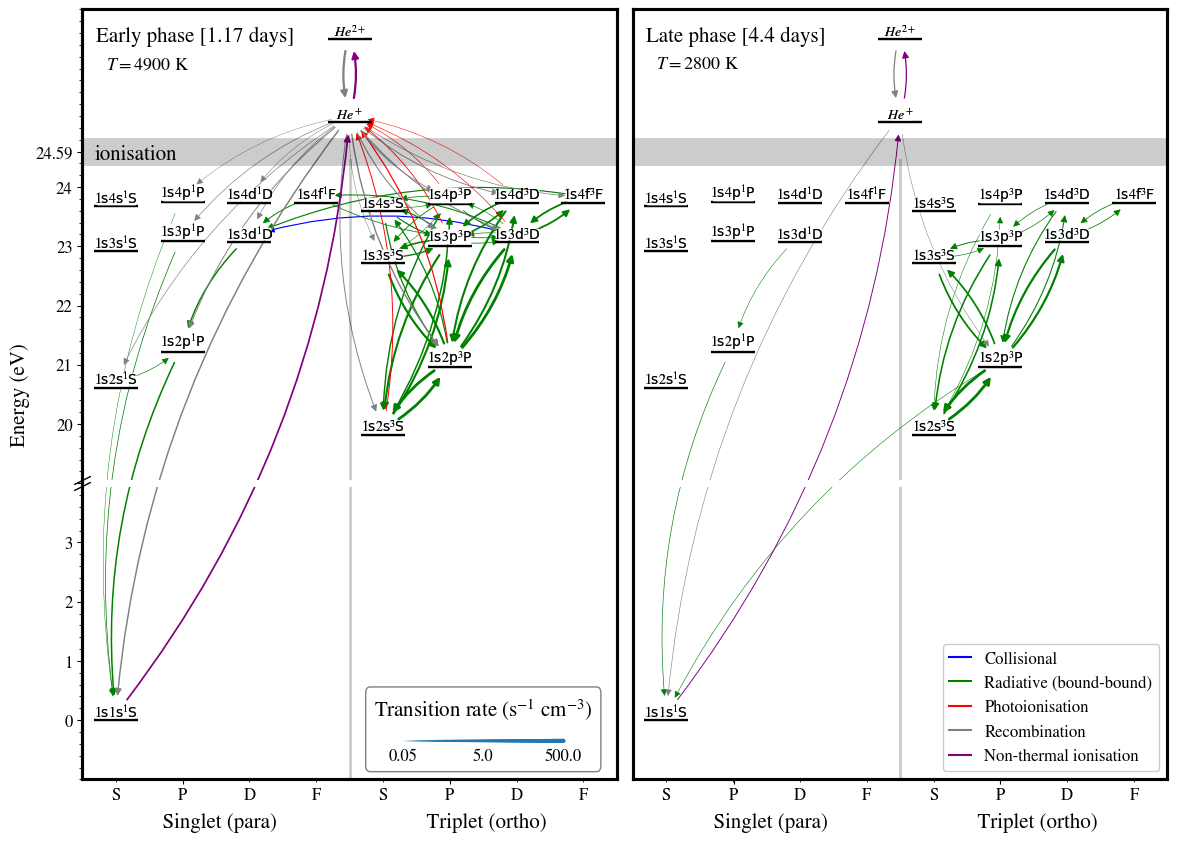

In [2]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
#matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(12, 15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
environments = [NLTE.NLTE_model.Environment(T_phot= 4900, photosphere_velocity= 0.30 , line_velocity= 0.30 , t_d=1.17),
                NLTE.NLTE_model.Environment(T_phot= 2800, photosphere_velocity= 0.19, line_velocity= 0.19, t_d=4.40),]

fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,10), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.05
max_rate = 5e2
max_width = 2


custom_colors = ['blue', 'green', 'red', 'grey', 'purple']

# Set the custom color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

#axes[0].set_prop_cycle(color=['red', 'green', 'blue'])
#axes[1].set_prop_cycle(color=['red', 'green', 'blue'])


for environment, ax, title in zip([environments[0], environments[-1]], axes, ["Early phase [1.17 days]", "Late phase [4.4 days]"]):
        ax.set_facecolor('white') #whitesmoke')

        
        ax.axis('on')
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(lambda table: table["n"] <= 4)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                        #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
                #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                x_pos = {name: "SPDF".index(name[2]) + (4 if name[1] == "3" else 0) for name in states.names}
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (3.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (3.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$ 1$s${name[0]}${name[2].lower()}$^{name[1]}${name[2]}" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                #nx.draw(G, final_pos, ax=ax,
                #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                #        with_labels=True, labels=labels, 
                #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
                #        verticalalignment="bottom", 
                #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=700 ,connectionstyle="arc3,rad=0.15",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1000)
                
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",font_size=10,
                                        bbox=dict(facecolor=ax.get_facecolor()*np.array([1,1,1,0.5]), alpha=0.5, edgecolor = ax.get_facecolor()*np.array([1,1,1,0.5]), boxstyle='square,pad=-0.2'))
                
                
                if process.name == 'Collision': 
                    ax.plot([],[], color=f'C{i}', label=f'Collisional')
                elif process.name == 'Radiative': 
                    ax.plot([],[], color=f'C{i}', label=f'Radiative (bound-bound)')                    
                elif process.name == 'Non-thermal electrons': 
                    ax.plot([],[], color=f'C{i}', label=f'Non-thermal ionisation') 
                elif process.name == 'Photoionization': 
                    ax.plot([],[], color=f'C{i}', label=f'Photoionisation') 
                else: 
                    ax.plot([],[], color=f'C{i}', label=f'{process.name}')
                    
                    
                    
        ax.set_ylim(14, 27)
        ax.plot([3.5, 3.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.01, 4.999])
        ax.set_xticklabels(["              Singlet (para)", "              Triplet (ortho)"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7], minor=True)

        ax.set_xticklabels(["S", "P", "D", "F", "S", "P", "D", "F"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        #ax.set_title(title)
        ax.text(ax.get_xlim()[0]+0.2, ax.get_ylim()[1]*0.98, title)

        ax.grid()
        ax.axis('on')
        
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)


ax.legend(loc="lower right", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)


# make width scale
axes[0].scatter(np.linspace(0.6,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.6, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
#axes[0].text(0.7, 0.03, str(round((min_rate*max_rate)**(1/5),3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
#axes[0].text(0.8, 0.03, str(round((min_rate*max_rate)**(4/5),3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(max_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.09, r"Transition rate (s$^{-1}$ cm$^{-3}$)", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.55, 0.03), 0.4, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0))
        
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes[0].set_ylabel("Energy (eV)")
axes[0].axhline(24.59, linestyle="-", linewidth=20, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=20, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "ionisation", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")

#axes[1].spines.left.set_visible(True)
#axes[0].set_title('Early phase [1.17 days]')

axes[0].text(-0.15, 26, r'$T = 4900$ K', fontsize=13)
#axes[0].text(-0.15, 25.55, r'$n_e\,\approx\,10^8$ cm$^{-3}$', fontsize=13)
axes[1].text(-0.15, 26, r'$T = 2800$ K', fontsize=13)
#axes[1].text(-0.15, 25.55, r'$n_e\,\approx\,2\cdot 10^7$ cm$^{-3}$', fontsize=13)

#plt.savefig(f"plots/transition_rates_n6_small.pdf", bbox_inches="tight", dpi=300)

Max flux:
Radiative                : 23P  -> 23S . Flux: 9.12e+03
Radiative                : 23S  -> 23P . Flux: 9.12e+03
Radiative                : 23P  -> 33D . Flux: 6.01e+02
Radiative                : 33D  -> 23P . Flux: 5.98e+02
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 2.64e+00
Radiative                : 43F  -> 31D . Flux: 2.31e+00
Collision                : 33D  -> 31D . Flux: 2.27e+00
Radiative                : 33D  -> 41F . Flux: 1.44e+00
Photoionization          : 23S  -> HeII. Flux: 1.17e+00
Photoionization          : 33P  -> HeII. Flux: 8.15e-01
Photoionization          : 33D  -> HeII. Flux: 3.58e-01
Photoionization          : 43P  -> HeII. Flux: 3.53e-01
Photoionization          : 43D  -> HeII. Flux: 2.42e-01
Photoionization          : 33S  -> HeII. Flux: 8.03e-02
Radiative                : 33D  -> 21P . Flux: 7.37e-02
Photoionization          : 43F  -> HeII. Flux: 6.88e-02
Radiative                : 23P  -> 11S . Flux: 5.72e-02
Photoionizati

Text(0.65, 0.09, 'Transition rate (s$^{-1}$ cm$^{-3}$)')

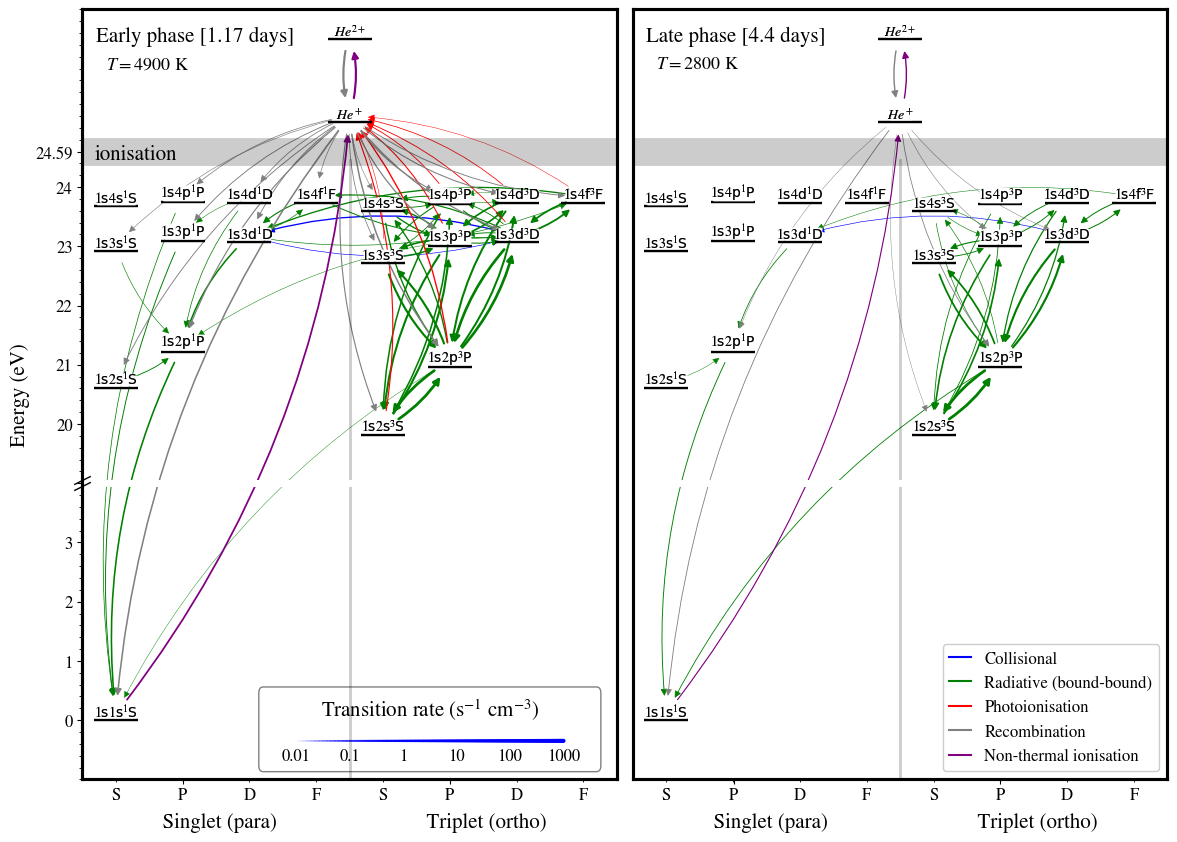

In [3]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
#matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(12, 15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,10), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.01
max_rate = 10e2
max_width = 2


custom_colors = ['blue', 'green', 'red', 'grey', 'purple']

# Set the custom color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

#axes[0].set_prop_cycle(color=['red', 'green', 'blue'])
#axes[1].set_prop_cycle(color=['red', 'green', 'blue'])


for environment, ax, title in zip([environments[0], environments[-1]], axes, ["Early phase [1.17 days]", "Late phase [4.4 days]"]):
        ax.set_facecolor('white') #whitesmoke')

        
        ax.axis('on')
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(lambda table: table["n"] <= 4)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                        #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
                #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                x_pos = {name: "SPDF".index(name[2]) + (4 if name[1] == "3" else 0) for name in states.names}
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (3.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (3.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$ 1$s${name[0]}${name[2].lower()}$^{name[1]}${name[2]}" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                #nx.draw(G, final_pos, ax=ax,
                #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                #        with_labels=True, labels=labels, 
                #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
                #        verticalalignment="bottom", 
                #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=700 ,connectionstyle="arc3,rad=0.15",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1000)
                
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",font_size=10,
                                        bbox=dict(facecolor=ax.get_facecolor()*np.array([1,1,1,0.5]), alpha=0.5, edgecolor = ax.get_facecolor()*np.array([1,1,1,0.5]), boxstyle='square,pad=-0.2'))
                
                
                if process.name == 'Collision': 
                    ax.plot([],[], color=f'C{i}', label=f'Collisional')
                elif process.name == 'Radiative': 
                    ax.plot([],[], color=f'C{i}', label=f'Radiative (bound-bound)')                    
                elif process.name == 'Non-thermal electrons': 
                    ax.plot([],[], color=f'C{i}', label=f'Non-thermal ionisation') 
                elif process.name == 'Photoionization': 
                    ax.plot([],[], color=f'C{i}', label=f'Photoionisation') 
                else: 
                    ax.plot([],[], color=f'C{i}', label=f'{process.name}')
                    
                    
                    
        ax.set_ylim(14, 27)
        ax.plot([3.5, 3.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.01, 4.999])
        ax.set_xticklabels(["              Singlet (para)", "              Triplet (ortho)"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7], minor=True)

        ax.set_xticklabels(["S", "P", "D", "F", "S", "P", "D", "F"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        #ax.set_title(title)
        ax.text(ax.get_xlim()[0]+0.2, ax.get_ylim()[1]*0.98, title)

        ax.grid()
        ax.axis('on')
        
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)


ax.legend(loc="lower right", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)


axes[0].set_ylabel("Energy (eV)")
axes[0].axhline(24.59, linestyle="-", linewidth=20, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=20, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "ionisation", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")



axes[0].text(-0.15, 26, r'$T = 4900$ K', fontsize=13)
#axes[0].text(-0.15, 25.55, r'$n_e\,\approx\,10^8$ cm$^{-3}$', fontsize=13)
axes[1].text(-0.15, 26, r'$T = 2800$ K', fontsize=13)
#axes[1].text(-0.15, 25.55, r'$n_e\,\approx\,2\cdot 10^7$ cm$^{-3}$', fontsize=13)


# make width scale
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.35, 0.03), 0.6, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0, alpha=1))
axes[0].scatter(np.linspace(0.4,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.4, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
#axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.5, 0.03, str(round(min_rate*(max_rate/min_rate)**(0.2),1)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.6, 0.03, str(int(round(min_rate*(max_rate/min_rate)**(0.4),0))), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.7, 0.03, str(int(round(min_rate*(max_rate/min_rate)**(0.6),0))), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.8, 0.03, str(int(round(min_rate*(max_rate/min_rate)**(0.8),0))), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(int(max_rate)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.65, 0.09, r"Transition rate (s$^{-1}$ cm$^{-3}$)", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
        


#axes[1].spines.left.set_visible(True)
#axes[0].set_title('Early phase [1.17 days]')

#plt.savefig(f"plots/transition_rates_n6.pdf", bbox_inches="tight", dpi=300)